<a href="https://colab.research.google.com/github/Vickes21/studies-notebooks/blob/main/2024/PUCPR/MFF/%5BMFF%5D_derivative_micro_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Micro Engine para cálculo de derivadas utilizando as regras de derivação e
# printando "step-by-step" a cada execução em LateX
# Opcionalmente plota o gráfico da função indicando os pontos críticos
#
# INSPIRADA EM https://github.com/sympy/sympy_gamma
# FOI FEITA PARA USO PESSOAL E PODE CONTER ERROS E BUGS
# Ainda não foi testado em todos os tipos de polinômios


##IMPORTS
import sympy
import collections
from contextlib import contextmanager
from sympy import latex
import six
from six.moves import range
from sympy.core.function import AppliedUndef
from sympy.functions.elementary.trigonometric import TrigonometricFunction
from sympy.strategies.core import switch
from six.moves import map
from six.moves import range
from six.moves import zip
from functools import reduce

import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np
from IPython.display import display, Markdown

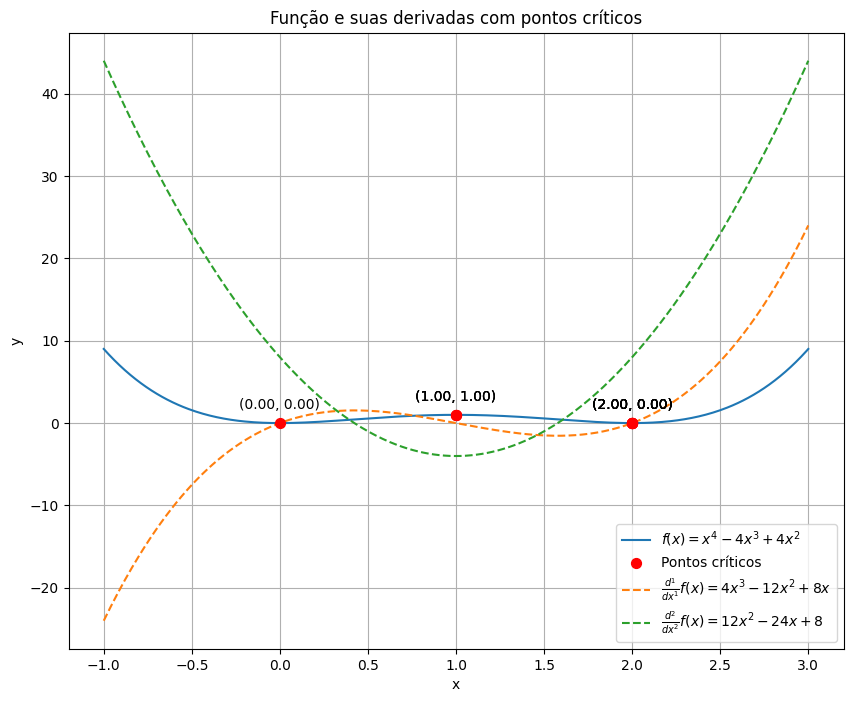

### Aplicando a regra da soma ou diferênça em $ x^{4} - 4 x^{3} + 4 x^{2} $ termo a termo:
  - Aplicando a regra da potência: $ x^{4} $ se torna $ 4 x^{3} $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{3} $ se torna $ 3 x^{2} $
  - Então, o resultado é: $ - 12 x^{2} $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{2} $ se torna $ 2 x $
  - Então, o resultado é: $ 8 x $
O resultado é: $ 4 x^{3} - 12 x^{2} + 8 x $

### Aplicando a regra da soma ou diferênça em $ 4 x^{3} - 12 x^{2} + 8 x $ termo a termo:
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{2} $ se torna $ 2 x $
  - Então, o resultado é: $ - 24 x $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x

In [ ]:
def Rule(name, props=""):
    # GOTCHA: namedtuple class name not considered!
    def __eq__(self, other):
        return self.__class__ == other.__class__ and tuple.__eq__(self, other)
    __neq__ = lambda self, other: not __eq__(self, other)
    cls = collections.namedtuple(name, props + " context symbol")
    cls.__eq__ = __eq__
    cls.__ne__ = __neq__
    return cls

def functionnames(numterms):
    if numterms == 2:
        return ["f", "g"]
    elif numterms == 3:
        return ["f", "g", "h"]
    else:
        return ["f_{}".format(i) for i in range(numterms)]

def replace_u_var(rule, old_u, new_u):
    d = rule._asdict()
    for field, val in d.items():
        if isinstance(val, sympy.Basic):
            d[field] = val.subs(old_u, new_u)
        elif isinstance(val, tuple):
            d[field] = replace_u_var(val, old_u, new_u)
        elif isinstance(val, list):
            result = []
            for item in val:
                if isinstance(item, tuple):
                    result.append(replace_u_var(item, old_u, new_u))
                else:
                    result.append(item)
            d[field] = result
    return rule.__class__(**d)

# def replace_all_u_vars(rule, replacements=None):
#     if replacements is None:
#         replacements = []

#     d = rule._asdict()
#     for field, val in d.items():
#         if isinstance(val, sympy.Basic):
#             for dummy in val.find(sympy.Dummy):
#                 replacements.append((dummy, ))
#         elif isinstance(val, tuple):
#             pass
#     return rule.__class__(**d)

class Printer(object):
    def __init__(self):
        self.lines = []
        self.level = 0

    def append(self, text):
        self.lines.append(self.level * "\t" + text)

    def finalize(self):
        return "\n".join(self.lines)

    def format_math(self, math):
        return str(math)

    def format_math_display(self, math):
        return self.format_math(math)

    @contextmanager
    def new_level(self):
        self.level += 1
        yield self.level
        self.level -= 1

    @contextmanager
    def new_step(self):
        yield self.level
        self.lines.append('\n')


class BaseLaTeXPrinter(Printer):
    def __init__(self):
        super(BaseLaTeXPrinter, self).__init__()

    def format_math(self, math):
        return '$ {} $'.format(latex(math))

    def format_math_display(self, math):
        return '$$ {} $$'.format(latex(math))

    @contextmanager
    def new_level(self):
        self.level += 1
        yield
        self.level -= 1

    @contextmanager
    def new_step(self):
        # self.lines.append('\n')
        yield self.level
        # self.lines.append('\n')

    def append(self, text):
        if self.level == 0:
            if len(self.lines) == 0:
                self.lines.append('### {}'.format(text))
            else:
                self.lines.append('{}'.format(text))
        else:
            self.lines.append('  ' * self.level + '- {}'.format(text))

    def finalize(self):
        return '\n'.join(self.lines)


class BaseHTMLPrinter(BaseLaTeXPrinter):
    def __init__(self):
        super(BaseHTMLPrinter, self).__init__()
        self.lines = ['<ol>']

    def format_math(self, math):
        return '<script type="math/tex; mode=inline">{}</script>'.format(
            latex(math))

    def format_math_display(self, math):
        if not isinstance(math, six.string_types):
            math = latex(math)
        return '<script type="math/tex; mode=display">{}</script>'.format(
            math)

    @contextmanager
    def new_level(self):
        self.level += 1
        self.lines.append(' ' * 4 * self.level + '<ol>')
        yield
        self.lines.append(' ' * 4 * self.level + '</ol>')
        self.level -= 1

    @contextmanager
    def new_step(self):
        self.lines.append(' ' * 4 * self.level + '<li>')
        yield self.level
        self.lines.append(' ' * 4 * self.level + '</li>')

    @contextmanager
    def new_collapsible(self):
        self.lines.append(' ' * 4 * self.level + '<div class="collapsible">')
        yield self.level
        self.lines.append(' ' * 4 * self.level + '</div>')

    @contextmanager
    def new_u_vars(self):
        self.u, self.du = sympy.Symbol('u'), sympy.Symbol('du')
        yield self.u, self.du

    def append(self, text):
        self.lines.append(' ' * 4 * (self.level + 1) + '<p>{}</p>'.format(text))

    def append_header(self, text):
        self.lines.append(' ' * 4 * (self.level + 1) + '<h2>{}</h2>'.format(text))


class BaseMarkdownPrinter(Printer):
    def __init__(self):
        super(BaseMarkdownPrinter, self).__init__()

    def format_math(self, math):
        return '$ {} $'.format(latex(math))

    def format_math_display(self, math):
        return '$$ {} $$'.format(latex(math))

    @contextmanager
    def new_level(self):
        self.level += 1
        yield
        self.level -= 1

    @contextmanager
    def new_step(self):
        # self.lines.append('\n')
        yield self.level
        # self.lines.append('\n')

    def append(self, text):
        if self.level == 0:
            if len(self.lines) == 0:
                self.lines.append('### {}'.format(text))
            else:
                self.lines.append('{}'.format(text))
        else:
            self.lines.append('  ' * self.level + '- {}'.format(text))

    def finalize(self):
        return '\n'.join(self.lines)





def Rule(name, props=""):
    return collections.namedtuple(name, props + " context symbol")


ConstantRule = Rule("ConstantRule", "number")
ConstantTimesRule = Rule("ConstantTimesRule", "constant other substep")
PowerRule = Rule("PowerRule", "base exp")
AddRule = Rule("AddRule", "substeps")
MulRule = Rule("MulRule", "terms substeps")
DivRule = Rule("DivRule", "numerator denominator numerstep denomstep")
ChainRule = Rule("ChainRule", "substep inner u_var innerstep")
TrigRule = Rule("TrigRule", "f")
ExpRule = Rule("ExpRule", "f base")
LogRule = Rule("LogRule", "arg base")
FunctionRule = Rule("FunctionRule")
AlternativeRule = Rule("AlternativeRule", "alternatives")
DontKnowRule = Rule("DontKnowRule")
RewriteRule = Rule("RewriteRule", "rewritten substep")

DerivativeInfo = collections.namedtuple('DerivativeInfo', 'expr symbol')

evaluators = {}


def evaluates(rule):
    def _evaluates(func):
        func.rule = rule
        evaluators[rule] = func
        return func

    return _evaluates


def power_rule(derivative):
    expr, symbol = derivative.expr, derivative.symbol
    base, exp = expr.as_base_exp()

    if not base.has(symbol):
        if isinstance(exp, sympy.Symbol):
            return ExpRule(expr, base, expr, symbol)
        else:
            u = sympy.Dummy()
            f = base ** u
            return ChainRule(
                ExpRule(f, base, f, u),
                exp, u,
                diff_steps(exp, symbol),
                expr, symbol
            )
    elif not exp.has(symbol):
        if isinstance(base, sympy.Symbol):
            return PowerRule(base, exp, expr, symbol)
        else:
            u = sympy.Dummy()
            f = u ** exp
            return ChainRule(
                PowerRule(u, exp, f, u),
                base, u,
                diff_steps(base, symbol),
                expr, symbol
            )
    else:
        return DontKnowRule(expr, symbol)


def add_rule(derivative):
    expr, symbol = derivative.expr, derivative.symbol
    return AddRule([diff_steps(arg, symbol) for arg in expr.args],
                   expr, symbol)


def constant_rule(derivative):
    expr, symbol = derivative.expr, derivative.symbol
    return ConstantRule(expr, expr, symbol)


def mul_rule(derivative):
    expr, symbol = derivative
    terms = expr.args
    is_div = 1 / sympy.Wild("denominator")

    coeff, f = expr.as_independent(symbol)

    if coeff != 1:
        return ConstantTimesRule(coeff, f, diff_steps(f, symbol), expr, symbol)

    numerator, denominator = expr.as_numer_denom()
    if denominator != 1:
        return DivRule(numerator, denominator,
                       diff_steps(numerator, symbol),
                       diff_steps(denominator, symbol), expr, symbol)

    return MulRule(terms, [diff_steps(g, symbol) for g in terms], expr, symbol)


def trig_rule(derivative):
    expr, symbol = derivative
    arg = expr.args[0]

    default = TrigRule(expr, expr, symbol)
    if not isinstance(arg, sympy.Symbol):
        u = sympy.Dummy()
        default = ChainRule(
            TrigRule(expr.func(u), expr.func(u), u),
            arg, u, diff_steps(arg, symbol),
            expr, symbol)

    if isinstance(expr, (sympy.sin, sympy.cos)):
        return default
    elif isinstance(expr, sympy.tan):
        f_r = sympy.sin(arg) / sympy.cos(arg)

        return AlternativeRule([
            default,
            RewriteRule(f_r, diff_steps(f_r, symbol), expr, symbol)
        ], expr, symbol)
    elif isinstance(expr, sympy.csc):
        f_r = 1 / sympy.sin(arg)

        return AlternativeRule([
            default,
            RewriteRule(f_r, diff_steps(f_r, symbol), expr, symbol)
        ], expr, symbol)
    elif isinstance(expr, sympy.sec):
        f_r = 1 / sympy.cos(arg)

        return AlternativeRule([
            default,
            RewriteRule(f_r, diff_steps(f_r, symbol), expr, symbol)
        ], expr, symbol)
    elif isinstance(expr, sympy.cot):
        f_r_1 = 1 / sympy.tan(arg)
        f_r_2 = sympy.cos(arg) / sympy.sin(arg)
        return AlternativeRule([
            default,
            RewriteRule(f_r_1, diff_steps(f_r_1, symbol), expr, symbol),
            RewriteRule(f_r_2, diff_steps(f_r_2, symbol), expr, symbol)
        ], expr, symbol)
    else:
        return DontKnowRule(f, symbol)


def exp_rule(derivative):
    expr, symbol = derivative
    exp = expr.args[0]
    if isinstance(exp, sympy.Symbol):
        return ExpRule(expr, sympy.E, expr, symbol)
    else:
        u = sympy.Dummy()
        f = sympy.exp(u)
        return ChainRule(ExpRule(f, sympy.E, f, u),
                         exp, u, diff_steps(exp, symbol), expr, symbol)


def log_rule(derivative):
    expr, symbol = derivative
    arg = expr.args[0]
    if len(expr.args) == 2:
        base = expr.args[1]
    else:
        base = sympy.E
        if isinstance(arg, sympy.Symbol):
            return LogRule(arg, base, expr, symbol)
        else:
            u = sympy.Dummy()
            return ChainRule(LogRule(u, base, sympy.log(u, base), u),
                             arg, u, diff_steps(arg, symbol), expr, symbol)


def function_rule(derivative):
    return FunctionRule(derivative.expr, derivative.symbol)


@evaluates(ConstantRule)
def eval_constant(*args):
    return 0


@evaluates(ConstantTimesRule)
def eval_constanttimes(constant, other, substep, expr, symbol):
    return constant * diff(substep)


@evaluates(AddRule)
def eval_add(substeps, expr, symbol):
    results = [diff(step) for step in substeps]
    return sum(results)


@evaluates(DivRule)
def eval_div(numer, denom, numerstep, denomstep, expr, symbol):
    d_numer = diff(numerstep)
    d_denom = diff(denomstep)
    return (denom * d_numer - numer * d_denom) / (denom ** 2)


@evaluates(ChainRule)
def eval_chain(substep, inner, u_var, innerstep, expr, symbol):
    return diff(substep).subs(u_var, inner) * diff(innerstep)


@evaluates(PowerRule)
@evaluates(ExpRule)
@evaluates(LogRule)
@evaluates(DontKnowRule)
@evaluates(FunctionRule)
def eval_default(*args):
    func, symbol = args[-2], args[-1]

    if isinstance(func, sympy.Symbol):
        func = sympy.Pow(func, 1, evaluate=False)

    # Automatically derive and apply the rule (don't use diff() directly as
    # chain rule is a separate step)
    substitutions = []
    mapping = {}
    constant_symbol = sympy.Dummy()
    for arg in func.args:
        if symbol in arg.free_symbols:
            mapping[symbol] = arg
            substitutions.append(symbol)
        else:
            mapping[constant_symbol] = arg
            substitutions.append(constant_symbol)

    rule = func.func(*substitutions).diff(symbol)
    return rule.subs(mapping)


@evaluates(MulRule)
def eval_mul(terms, substeps, expr, symbol):
    diffs = list(map(diff, substeps))

    result = sympy.S.Zero
    for i in range(len(terms)):
        subresult = diffs[i]
        for index, term in enumerate(terms):
            if index != i:
                subresult *= term
        result += subresult
    return result


@evaluates(TrigRule)
def eval_default_trig(*args):
    return sympy.trigsimp(eval_default(*args))


@evaluates(RewriteRule)
def eval_rewrite(rewritten, substep, expr, symbol):
    return diff(substep)


@evaluates(AlternativeRule)
def eval_alternative(alternatives, expr, symbol):
    return diff(alternatives[1])


def diff_steps(expr, symbol):
    deriv = DerivativeInfo(expr, symbol)

    def key(deriv):
        expr = deriv.expr
        if isinstance(expr, TrigonometricFunction):
            return TrigonometricFunction
        elif isinstance(expr, AppliedUndef):
            return AppliedUndef
        elif not expr.has(symbol):
            return 'constant'
        else:
            return expr.func

    return switch(key, {
        sympy.Pow: power_rule,
        sympy.Symbol: power_rule,
        sympy.Dummy: power_rule,
        sympy.Add: add_rule,
        sympy.Mul: mul_rule,
        TrigonometricFunction: trig_rule,
        sympy.exp: exp_rule,
        sympy.log: log_rule,
        AppliedUndef: function_rule,
        'constant': constant_rule
    })(deriv)


def diff(rule):
    try:
        return evaluators[rule.__class__](*rule)
    except KeyError:
        raise ValueError("Cannot evaluate derivative")


class DiffPrinter(object):
    def __init__(self, rule):
        self.print_rule(rule)
        self.rule = rule

    def print_rule(self, rule):
        if isinstance(rule, PowerRule):
            self.print_Power(rule)
        elif isinstance(rule, ChainRule):
            self.print_Chain(rule)
        elif isinstance(rule, ConstantRule):
            self.print_Number(rule)
        elif isinstance(rule, ConstantTimesRule):
            self.print_ConstantTimes(rule)
        elif isinstance(rule, AddRule):
            self.print_Add(rule)
        elif isinstance(rule, MulRule):
            self.print_Mul(rule)
        elif isinstance(rule, DivRule):
            self.print_Div(rule)
        elif isinstance(rule, TrigRule):
            self.print_Trig(rule)
        elif isinstance(rule, ExpRule):
            self.print_Exp(rule)
        elif isinstance(rule, LogRule):
            self.print_Log(rule)
        elif isinstance(rule, DontKnowRule):
            self.print_DontKnow(rule)
        elif isinstance(rule, AlternativeRule):
            self.print_Alternative(rule)
        elif isinstance(rule, RewriteRule):
            self.print_Rewrite(rule)
        elif isinstance(rule, FunctionRule):
            self.print_Function(rule)
        else:
            self.append(repr(rule))

    def print_Power(self, rule):
        with self.new_step():
            self.append("Aplicando a regra da potência: {0} se torna {1}".format(
                self.format_math(rule.context),
                self.format_math(diff(rule))))

    def print_Number(self, rule):
        with self.new_step():
            self.append("A derivada da constante {} é zero.".format(
                self.format_math(rule.number)))

    def print_ConstantTimes(self, rule):
        with self.new_step():
            self.append("A derivada de um constante vezes uma função é a constante vezes a derivada da função.")
            with self.new_level():
                self.print_rule(rule.substep)
            self.append("Então, o resultado é: {}".format(
                self.format_math(diff(rule))))

    def print_Add(self, rule):
        with self.new_step():
            self.append("Aplicando a regra da soma ou diferênça em {} termo a termo:".format(
                self.format_math(rule.context)))
            with self.new_level():
                for substep in rule.substeps:
                    self.print_rule(substep)
            self.append("O resultado é: {}".format(
                self.format_math(diff(rule))))

    def print_Mul(self, rule):
        with self.new_step():
            self.append("Aplicando a regra do produto:".format(
                self.format_math(rule.context)))

            fnames = [sympy.Function(n)(rule.symbol) for n in functionnames(len(rule.terms))]
            derivatives = [sympy.Derivative(f, rule.symbol) for f in fnames]
            ruleform = []
            for index in range(len(rule.terms)):
                buf = []
                for i in range(len(rule.terms)):
                    if i == index:
                        buf.append(derivatives[i])
                    else:
                        buf.append(fnames[i])
                ruleform.append(reduce(lambda a, b: a * b, buf))
            self.append(self.format_math_display(
                sympy.Eq(sympy.Derivative(reduce(lambda a, b: a * b, fnames),
                                          rule.symbol),
                         sum(ruleform))))

            for fname, deriv, term, substep in zip(fnames, derivatives,
                                                   rule.terms, rule.substeps):
                self.append("{}; para encontrar {}:".format(
                    self.format_math(sympy.Eq(fname, term)),
                    self.format_math(deriv)
                ))
                with self.new_level():
                    self.print_rule(substep)

            self.append("O resultado é: " + self.format_math(diff(rule)))

    def print_Div(self, rule):
        with self.new_step():
            f, g = rule.numerator, rule.denominator
            fp, gp = f.diff(rule.symbol), g.diff(rule.symbol)
            x = rule.symbol
            ff = sympy.Function("f")(x)
            gg = sympy.Function("g")(x)
            qrule_left = sympy.Derivative(ff / gg, rule.symbol)
            qrule_right = sympy.ratsimp(sympy.diff(sympy.Function("f")(x) /
                                                   sympy.Function("g")(x)))
            qrule = sympy.Eq(qrule_left, qrule_right)
            self.append("Aplicando a regra do quociente, que é:")
            self.append(self.format_math_display(qrule))
            self.append("{} e {}.".format(self.format_math(sympy.Eq(ff, f)),
                                          self.format_math(sympy.Eq(gg, g))))
            self.append("Para encontrar {}:".format(self.format_math(ff.diff(rule.symbol))))
            with self.new_level():
                self.print_rule(rule.numerstep)
            self.append("Para encontrar {}:".format(self.format_math(gg.diff(rule.symbol))))
            with self.new_level():
                self.print_rule(rule.denomstep)
            self.append("Agora substituindo na regra do quociente:")
            self.append(self.format_math(diff(rule)))

    def print_Chain(self, rule):
        with self.new_step(), self.new_u_vars() as (u, du):
            self.append("Let {}.".format(self.format_math(sympy.Eq(u, rule.inner))))
            self.print_rule(replace_u_var(rule.substep, rule.u_var, u))
        with self.new_step():
            if isinstance(rule.innerstep, FunctionRule):
                self.append(
                    "Agora, aplicando a regra de cadeia. Multiplicar por {}:".format(
                        self.format_math(
                            sympy.Derivative(rule.inner, rule.symbol))))
                self.append(self.format_math_display(diff(rule)))
            else:
                self.append(
                    "Agora, aplicando a regra de cadeia. Multiplicar por {}:".format(
                        self.format_math(
                            sympy.Derivative(rule.inner, rule.symbol))))
                with self.new_level():
                    self.print_rule(rule.innerstep)
                self.append("O resultado da regra de cadeia é:")
                self.append(self.format_math_display(diff(rule)))

    def print_Trig(self, rule):
        with self.new_step():
            if isinstance(rule.f, sympy.sin):
                self.append("A derivada do seno é o cosseno:")
            elif isinstance(rule.f, sympy.cos):
                self.append("A derivada do cosseno é o negativo do seno:")
            elif isinstance(rule.f, sympy.sec):
                self.append("A derivada da secante é a secante vezes a tangente:")
            elif isinstance(rule.f, sympy.csc):
                self.append("A derivada da cossecante é negativo da cossecante vezes a cotangente:")
            self.append("{}".format(
                self.format_math_display(sympy.Eq(
                    sympy.Derivative(rule.f, rule.symbol),
                    diff(rule)))))

    def print_Exp(self, rule):
        with self.new_step():
            if rule.base == sympy.E:
                self.append("A derivada de {} é ela mesma.".format(
                    self.format_math(sympy.exp(rule.symbol))))
            else:
                self.append(
                    self.format_math(sympy.Eq(sympy.Derivative(rule.f, rule.symbol),
                                              diff(rule))))

    def print_Log(self, rule):
        with self.new_step():
            if rule.base == sympy.E:
                self.append("A derivada de {} é {}.".format(
                    self.format_math(rule.context),
                    self.format_math(diff(rule))
                ))
            else:
                # This case shouldn't come up often, seeing as SymPy
                # automatically applies the change-of-base identity
                self.append("A derivada de {} é {}.".format(
                    self.format_math(sympy.log(rule.symbol, rule.base,
                                               evaluate=False)),
                    self.format_math(1 / (rule.arg * sympy.ln(rule.base)))))
                self.append("Então {}".format(
                    self.format_math(sympy.Eq(
                        sympy.Derivative(rule.context, rule.symbol),
                        diff(rule)))))

    def print_Alternative(self, rule):
        with self.new_step():
            self.append("Existe mais de uma maneira de fazer essa derivada.")
            self.append("Uma delas:")
            with self.new_level():
                self.print_rule(rule.alternatives[0])

    def print_Rewrite(self, rule):
        with self.new_step():
            self.append("Rescrevendo a função a ser derivada:")
            self.append(self.format_math_display(
                sympy.Eq(rule.context, rule.rewritten)))
            self.print_rule(rule.substep)

    def print_Function(self, rule):
        with self.new_step():
            self.append("Trivial:")
            self.append(self.format_math_display(
                sympy.Eq(sympy.Derivative(rule.context, rule.symbol),
                         diff(rule))))

    def print_DontKnow(self, rule):
        with self.new_step():
            self.append("Não se conhece os passos para encontrar essa derivada.")
            self.append("Mas a derivada é")
            self.append(self.format_math_display(diff(rule)))


class HTMLPrinter(DiffPrinter, BaseHTMLPrinter):
    def __init__(self, rule):
        self.alternative_functions_printed = set()
        BaseHTMLPrinter.__init__(self)
        DiffPrinter.__init__(self, rule)

    def print_Alternative(self, rule):
        if rule.context.func in self.alternative_functions_printed:
            self.print_rule(rule.alternatives[0])
        elif len(rule.alternatives) == 2:
            self.alternative_functions_printed.add(rule.context.func)
            self.print_rule(rule.alternatives[1])
        else:
            self.alternative_functions_printed.add(rule.context.func)
            with self.new_step():
                self.append("There are multiple ways to do this derivative.")
                for index, r in enumerate(rule.alternatives[1:]):
                    with self.new_collapsible():
                        self.append_header("Method #{}".format(index + 1))
                        with self.new_level():
                            self.print_rule(r)

    def finalize(self):
        answer = diff(self.rule)
        if answer:
            simp = sympy.simplify(answer)
            if simp != answer:
                answer = simp
                with self.new_step():
                    self.append("Now simplify:")
                    self.append(self.format_math_display(simp))
        self.lines.append('</ol>')
        self.lines.append('<hr/>')
        self.level = 0
        self.append('The answer is:')
        self.append(self.format_math_display(answer))
        return '\n'.join(self.lines)


class LateXPrinter(DiffPrinter, BaseLaTeXPrinter):
    def __init__(self, rule):
        BaseLaTeXPrinter.__init__(self)
        DiffPrinter.__init__(self, rule)


class MarkdownPrinter(DiffPrinter, BaseMarkdownPrinter):
    def __init__(self, rule):
        BaseMarkdownPrinter.__init__(self)
        DiffPrinter.__init__(self, rule)


def print_html_steps(function, symbol):
    steps = diff_steps(function, symbol)
    a = HTMLPrinter(steps)
    return a.finalize()


def print_latex_steps(function, symbol):
    steps = diff_steps(function, symbol)
    a = LateXPrinter(steps)
    return a.finalize()


def print_markdown_steps(function, symbol):
    steps = diff_steps(function, symbol)
    a = MarkdownPrinter(steps)
    return a.finalize()


def plot_function_and_derivatives(function_str, num_derivatives=1, x_range=(-10, 10), num_points=400):
    # Using global symbolic variable 'x'
    global x

    # Convert the string expression into a symbolic expression
    expr = sympy.sympify(function_str)

    # List to hold all functions including the original and its derivatives
    functions = [expr]

    # Generate derivatives
    for _ in range(num_derivatives):
        # Derive the last function in the list
        expr = sympy.diff(expr, x)
        functions.append(expr)

    # Prepare plot
    plt.figure(figsize=(10, 8))
    x_vals = np.linspace(x_range[0], x_range[1], num_points)

    # Identify critical points numerically for non-constant derivatives
    critical_points = []
    if num_derivatives > 0:
        first_derivative = functions[1]
        num_first_derivative = sympy.lambdify(x, first_derivative, modules=['numpy'])

        if not first_derivative.is_constant():
            # Generate initial guesses across the range
            guesses = np.linspace(x_range[0], x_range[1], 20)
            for guess in guesses:
                try:
                    root = opt.fsolve(num_first_derivative, guess)[0]
                    if x_range[0] <= root <= x_range[1] and root not in critical_points:
                        # Check if it's really a root
                        if np.isclose(num_first_derivative(root), 0, atol=1e-5):
                            critical_points.append(root)
                except (RuntimeError, TypeError):
                    continue

    # Plot each function with checking for constant output
    for i, func in enumerate(functions):
        # Convert symbolic expression to a numerical function
        num_func = sympy.lambdify(x, func, modules=['numpy'])
        try:
            y_vals = num_func(x_vals)
            if np.isscalar(y_vals):
                y_vals = np.full(x_vals.shape, y_vals)
        except Exception as e:
            y_vals = np.full(x_vals.shape, num_func(0))

        # Adjust label and style for the main function and derivatives
        if i == 0:
            label = '$f(x) = ' + sympy.latex(func) + '$'
            line_style = '-'
            plt.plot(x_vals, y_vals, label=label, linestyle=line_style)
            # Highlight critical points on the main function's graph
            if critical_points:
                cp_y_vals = [num_func(cp_x) for cp_x in critical_points]
                plt.scatter(critical_points, cp_y_vals, color='red', s=50, zorder=5, label='Pontos críticos')
                # Annotate critical points
                for (cp_x, cp_y) in zip(critical_points, cp_y_vals):
                    plt.annotate(f'({cp_x:.2f}, {cp_y:.2f})', (cp_x, cp_y), textcoords="offset points", xytext=(0, 10),
                                 ha='center')
        else:
            label = f'$\\frac{{d^{i}}}{{dx^{i}}} f(x) = {sympy.latex(func)}$'
            line_style = '--'
            plt.plot(x_vals, y_vals, label=label, linestyle=line_style)

    # Customize and show plot
    # plt.title('Graph of the Function and Its Derivatives with Critical Points (Numerical)')
    plt.title('Função e suas derivadas com pontos críticos')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

def run(exp, num_derivatives=1, plot=True, print_type='markdown', x_range=(-10, 10)):
    # Generate derivatives
    current_fn = exp
    outputs = []
    for _ in range(num_derivatives):
        # Print steps
        if print_type == 'markdown':
            outputs.append(print_markdown_steps(current_fn, x))
        elif print_type == 'latex':
            outputs.append(print_latex_steps(current_fn, x))
        elif print_type == 'html':
            outputs.append(print_html_steps(current_fn, x))
        else:
            raise ValueError('Invalid print type')

        # Derive the last function in the list
        current_fn = sympy.diff(current_fn, x)

    if plot:
        plot_function_and_derivatives(
            exp,
            num_derivatives=num_derivatives,
            x_range=x_range,
        )

    return outputs


### ------------- RUN INICIAL --------------- ###

x = sympy.symbols('x')

# exp_str = '3 * x ** 2 - 5 * sin(x) + 7'
# exp_str = 'x ** 2'
exp_str = 'x**4-4*x**3+4*x**2'
exp = sympy.sympify(exp_str)
outputs = run(exp, #FUNÇÃO ORIGINAL
              num_derivatives=2, #NUMERO DE DERIVADAS
              plot=True, #PLOTAR OU NÃO
              print_type='latex', #'latex', 'html', 'markdown'
              x_range=(-1, 3) #RANGE DO EIXO X
              )

for output in outputs:
    # display(Markdown(output)) #CASO QUEIRA VISUALIZAR O MARDOWN FORMATADO
    print(output + "\n") #NECESSÁRIO PRINTAR PARA CONSEGUIR COPIAR O CONTEUDO


### Aplicando a regra da soma ou diferênça em $ x^{4} - 4 x^{3} + 4 x^{2} $ termo a termo:
  - Aplicando a regra da potência: $ x^{4} $ se torna $ 4 x^{3} $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{3} $ se torna $ 3 x^{2} $
  - Então, o resultado é: $ - 12 x^{2} $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{2} $ se torna $ 2 x $
  - Então, o resultado é: $ 8 x $
O resultado é: $ 4 x^{3} - 12 x^{2} + 8 x $

### Aplicando a regra da soma ou diferênça em $ 4 x^{3} - 12 x^{2} + 8 x $ termo a termo:
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{2} $ se torna $ 2 x $
  - Então, o resultado é: $ - 24 x $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x^{3} $ se torna $ 3 x^{2} $
  - Então, o resultado é: $ 12 x^{2} $
  - A derivada de um constante vezes uma função é a constante vezes a derivada da função.
    - Aplicando a regra da potência: $ x $ se torna $ 1 $
  - Então, o resultado é: $ 8 $
O resultado é: $ 12 x^{2} - 24 x + 8 $